In [1]:
import pandas as pd
import numpy as np
import os

from glob import glob
import json
from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "3"
os.environ['CUDA_VISIBLE_DEVICES'] = "3"

### 데이터 로드

In [3]:
DIR = "./data"
TRAIN_SOURCE = os.path.join(DIR, "train.json")
TEST_SOURCE = os.path.join(DIR, "test.json")
sample_submission = pd.read_csv("data/sample_submission.csv")

In [4]:
with open(TRAIN_SOURCE) as f:
    TRAIN_DATA = json.loads(f.read())
    
with open(TEST_SOURCE) as f:
    TEST_DATA = json.loads(f.read())

In [5]:
train = pd.DataFrame(columns=['uid', 'title', 'region', 'context', 'summary'])
uid = 1000
for data in TRAIN_DATA:
    for agenda in data['context'].keys():
        context = ''
        for line in data['context'][agenda]:
            context += data['context'][agenda][line]
            context += ' '
        train.loc[uid, 'uid'] = uid
        train.loc[uid, 'title'] = data['title']
        train.loc[uid, 'region'] = data['region']
        train.loc[uid, 'context'] = context[:-1]
        train.loc[uid, 'summary'] = data['label'][agenda]['summary']
        uid += 1

test = pd.DataFrame(columns=['uid', 'title', 'region', 'context'])
uid = 2000
for data in TEST_DATA:
    for agenda in data['context'].keys():
        context = ''
        for line in data['context'][agenda]:
            context += data['context'][agenda][line]
            context += ' '
        test.loc[uid, 'uid'] = uid
        test.loc[uid, 'title'] = data['title']
        test.loc[uid, 'region'] = data['region']
        test.loc[uid, 'context'] = context[:-1]
        uid += 1


In [6]:
train.head()

,uid,title,region,context,summary
1000,1000,제207회 완주군의회(임시회) 제 1 차 본회의회의록,완주,의석을 정돈하여 주시기 바랍니다. 성원이 되었으므로 제207회 완주군의회 임시회 제...,제207회 완주군의회 임시회 제1차 본회의 개의 선포.
1001,1001,제207회 완주군의회(임시회) 제 1 차 본회의회의록,완주,의사팀장 수고하셨습니다. 먼저 의사일정 제1항 제207회 완주군의회 임시회 회기 결...,제207회 완주군의회 임시회 회기는 8월 26일부터 9월 4일까지 10일간으로 가결됨.
1002,1002,제207회 완주군의회(임시회) 제 1 차 본회의회의록,완주,다음은 의사일정 제2항 제207회 완주군의회 임시회 회의록 서명의원 선출의 건을 상...,제207회 완주군의회 임시회 회의록 서명의원으로 최등원 의원과 박웅배 의원이 선출됨.
1003,1003,제207회 완주군의회(임시회) 제 1 차 본회의회의록,완주,다음은 의사일정 제3항 본회의 휴회의 건을 상정합니다. 상임의원회 의정활동을 위하여...,8월 27일부터 9월 3일까지 8일간 휴회가 가결됨. 제2차 본회의는 9월 4일 오...
1004,1004,제251회 완주군의회(제1차 정례회) 제1차 본 회 의 회 의 록,완주,의석을 정돈하여 주시기 바랍니다. 성원이 되었으므로 제251회 완주군의회 제1차 정...,제251회 완주군의회 제1차 정례회 제1차 본회의 개의 선포.


In [7]:
train['total'] = train.title + ' ' + train.region + ' ' + train.context
test['total'] = test.title + ' ' + test.region + ' ' + test.context

In [8]:
train.head()

,uid,title,region,context,summary,total
1000,1000,제207회 완주군의회(임시회) 제 1 차 본회의회의록,완주,의석을 정돈하여 주시기 바랍니다. 성원이 되었으므로 제207회 완주군의회 임시회 제...,제207회 완주군의회 임시회 제1차 본회의 개의 선포.,제207회 완주군의회(임시회) 제 1 차 본회의회의록 완주 의석을 정돈하여 주시기 ...
1001,1001,제207회 완주군의회(임시회) 제 1 차 본회의회의록,완주,의사팀장 수고하셨습니다. 먼저 의사일정 제1항 제207회 완주군의회 임시회 회기 결...,제207회 완주군의회 임시회 회기는 8월 26일부터 9월 4일까지 10일간으로 가결됨.,제207회 완주군의회(임시회) 제 1 차 본회의회의록 완주 의사팀장 수고하셨습니다....
1002,1002,제207회 완주군의회(임시회) 제 1 차 본회의회의록,완주,다음은 의사일정 제2항 제207회 완주군의회 임시회 회의록 서명의원 선출의 건을 상...,제207회 완주군의회 임시회 회의록 서명의원으로 최등원 의원과 박웅배 의원이 선출됨.,제207회 완주군의회(임시회) 제 1 차 본회의회의록 완주 다음은 의사일정 제2항 ...
1003,1003,제207회 완주군의회(임시회) 제 1 차 본회의회의록,완주,다음은 의사일정 제3항 본회의 휴회의 건을 상정합니다. 상임의원회 의정활동을 위하여...,8월 27일부터 9월 3일까지 8일간 휴회가 가결됨. 제2차 본회의는 9월 4일 오...,제207회 완주군의회(임시회) 제 1 차 본회의회의록 완주 다음은 의사일정 제3항 ...
1004,1004,제251회 완주군의회(제1차 정례회) 제1차 본 회 의 회 의 록,완주,의석을 정돈하여 주시기 바랍니다. 성원이 되었으므로 제251회 완주군의회 제1차 정...,제251회 완주군의회 제1차 정례회 제1차 본회의 개의 선포.,제251회 완주군의회(제1차 정례회) 제1차 본 회 의 회 의 록 완주 의석을 정돈...


In [9]:
train_sum = train[['uid', 'total', 'summary']]

In [10]:
train_sum.head()

,uid,total,summary
1000,1000,제207회 완주군의회(임시회) 제 1 차 본회의회의록 완주 의석을 정돈하여 주시기 ...,제207회 완주군의회 임시회 제1차 본회의 개의 선포.
1001,1001,제207회 완주군의회(임시회) 제 1 차 본회의회의록 완주 의사팀장 수고하셨습니다....,제207회 완주군의회 임시회 회기는 8월 26일부터 9월 4일까지 10일간으로 가결됨.
1002,1002,제207회 완주군의회(임시회) 제 1 차 본회의회의록 완주 다음은 의사일정 제2항 ...,제207회 완주군의회 임시회 회의록 서명의원으로 최등원 의원과 박웅배 의원이 선출됨.
1003,1003,제207회 완주군의회(임시회) 제 1 차 본회의회의록 완주 다음은 의사일정 제3항 ...,8월 27일부터 9월 3일까지 8일간 휴회가 가결됨. 제2차 본회의는 9월 4일 오...
1004,1004,제251회 완주군의회(제1차 정례회) 제1차 본 회 의 회 의 록 완주 의석을 정돈...,제251회 완주군의회 제1차 정례회 제1차 본회의 개의 선포.


### 데이터 전처리

In [11]:
train_data = train_sum.iloc[:-200, :].copy()
val_data = train_sum.iloc[-200:, :].copy()

In [12]:
train_data["decoder_input"] = train_data["summary"].apply(lambda x : "sostoken " + str(x))
train_data["decoder_target"] = train_data["summary"].apply(lambda x : str(x) + " eostoken")

encoder_input = train_data["total"]
decoder_input = train_data["decoder_input"]
decoder_output = train_data["decoder_target"]

In [13]:
train_data.head()

,uid,total,summary,decoder_input,decoder_target
1000,1000,제207회 완주군의회(임시회) 제 1 차 본회의회의록 완주 의석을 정돈하여 주시기 ...,제207회 완주군의회 임시회 제1차 본회의 개의 선포.,sostoken 제207회 완주군의회 임시회 제1차 본회의 개의 선포.,제207회 완주군의회 임시회 제1차 본회의 개의 선포. eostoken
1001,1001,제207회 완주군의회(임시회) 제 1 차 본회의회의록 완주 의사팀장 수고하셨습니다....,제207회 완주군의회 임시회 회기는 8월 26일부터 9월 4일까지 10일간으로 가결됨.,sostoken 제207회 완주군의회 임시회 회기는 8월 26일부터 9월 4일까지 ...,제207회 완주군의회 임시회 회기는 8월 26일부터 9월 4일까지 10일간으로 가결...
1002,1002,제207회 완주군의회(임시회) 제 1 차 본회의회의록 완주 다음은 의사일정 제2항 ...,제207회 완주군의회 임시회 회의록 서명의원으로 최등원 의원과 박웅배 의원이 선출됨.,sostoken 제207회 완주군의회 임시회 회의록 서명의원으로 최등원 의원과 박웅...,제207회 완주군의회 임시회 회의록 서명의원으로 최등원 의원과 박웅배 의원이 선출됨...
1003,1003,제207회 완주군의회(임시회) 제 1 차 본회의회의록 완주 다음은 의사일정 제3항 ...,8월 27일부터 9월 3일까지 8일간 휴회가 가결됨. 제2차 본회의는 9월 4일 오...,sostoken 8월 27일부터 9월 3일까지 8일간 휴회가 가결됨. 제2차 본회의...,8월 27일부터 9월 3일까지 8일간 휴회가 가결됨. 제2차 본회의는 9월 4일 오...
1004,1004,제251회 완주군의회(제1차 정례회) 제1차 본 회 의 회 의 록 완주 의석을 정돈...,제251회 완주군의회 제1차 정례회 제1차 본회의 개의 선포.,sostoken 제251회 완주군의회 제1차 정례회 제1차 본회의 개의 선포.,제251회 완주군의회 제1차 정례회 제1차 본회의 개의 선포. eostoken


In [14]:
val_data["decoder_input"] = val_data["summary"].apply(lambda x : "sostoken " + x)
val_data["decoder_target"] = val_data["summary"].apply(lambda x : x + " eostoken")

encoder_input_val = val_data["total"]
decoder_input_val = val_data["decoder_input"]
decoder_output_val = val_data["decoder_target"]

In [15]:
val_data.head()

,uid,total,summary,decoder_input,decoder_target
3794,3794,"제311회 본회의 제1차(2019.05.21.) 음성 의사일정 제8항, 음성군...",음성군 경로당 지원 조례 일부개정조례안은 경로당 이용에 대한 여건 및 특수성에 따라...,sostoken 음성군 경로당 지원 조례 일부개정조례안은 경로당 이용에 대한 여건 ...,음성군 경로당 지원 조례 일부개정조례안은 경로당 이용에 대한 여건 및 특수성에 따라...
3795,3795,"제311회 본회의 제1차(2019.05.21.) 음성 의사일정 제9항, 음성군...",음성군 군세 징수 조례 일부개정조례안과 2019년 재산세 도시지역분 적용대상 지역 ...,sostoken 음성군 군세 징수 조례 일부개정조례안과 2019년 재산세 도시지역분...,음성군 군세 징수 조례 일부개정조례안과 2019년 재산세 도시지역분 적용대상 지역 ...
3796,3796,"제311회 본회의 제1차(2019.05.21.) 음성 의사일정 제11항, 음성...",음성군 폐기물 관리 조례 일부개정조례안은 쓰레기처리비 대비 수수료 수입비율인 주민부...,sostoken 음성군 폐기물 관리 조례 일부개정조례안은 쓰레기처리비 대비 수수료 ...,음성군 폐기물 관리 조례 일부개정조례안은 쓰레기처리비 대비 수수료 수입비율인 주민부...
3797,3797,"제311회 본회의 제1차(2019.05.21.) 음성 의사일정 제12항, 음성...",음성군 농업기계 사후관리 출장비용 지원 조례안은 음성군 농업인의 농업생산성 향상과 ...,sostoken 음성군 농업기계 사후관리 출장비용 지원 조례안은 음성군 농업인의 농...,음성군 농업기계 사후관리 출장비용 지원 조례안은 음성군 농업인의 농업생산성 향상과 ...
3798,3798,"제311회 본회의 제1차(2019.05.21.) 음성 의사일정 제13항, 일반...",일반농산어촌개발사업 공유재산 시설물 관리위탁 운영 동의안은 조성한 시설물의 효율적인...,sostoken 일반농산어촌개발사업 공유재산 시설물 관리위탁 운영 동의안은 조성한 ...,일반농산어촌개발사업 공유재산 시설물 관리위탁 운영 동의안은 조성한 시설물의 효율적인...


# 정수 인코딩

In [16]:
'''src_tokenizer = Tokenizer()
src_tokenizer.fit_on_texts(encoder_input)'''

'src_tokenizer = Tokenizer()\nsrc_tokenizer.fit_on_texts(encoder_input)'

In [17]:
src_vocab = 20000
src_tokenizer = Tokenizer(num_words=src_vocab)
src_tokenizer.fit_on_texts(encoder_input)

encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input)
encoder_input_val = src_tokenizer.texts_to_sequences(encoder_input_val)

In [18]:
'''tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input)'''

'tar_tokenizer = Tokenizer()\ntar_tokenizer.fit_on_texts(decoder_input)'

In [19]:
tar_vocab = 20000
tar_tokenizer = Tokenizer(num_words = tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input)
tar_tokenizer.fit_on_texts(decoder_output)

In [20]:
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_output)
decoder_input_val = tar_tokenizer.texts_to_sequences(decoder_input_val)
decoder_target_val = tar_tokenizer.texts_to_sequences(decoder_output_val)

In [21]:
text_max_len = 100
summary_max_len = 100

# 패딩하기
-계산해둔 최대 길이로 맞추어 데이터와 데스트 데이터에 대해서 패딩 작업

In [22]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen = text_max_len, padding='post')
encoder_input_val = pad_sequences(encoder_input_val, maxlen = text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen = summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = summary_max_len, padding='post')
decoder_input_val = pad_sequences(decoder_input_val, maxlen = summary_max_len, padding='post')
decoder_target_val = pad_sequences(decoder_target_val, maxlen = summary_max_len, padding='post')

# seq2seq + attention으로 요약 모델 설계 및 훈련

In [23]:
embedding_dim = 128
hidden_size = 256
# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# # 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

## 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

## 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [24]:
# 디코더
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])

In [25]:
# # 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation = 'softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 128)     2560000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 100, 256), ( 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [26]:
import urllib.request

urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

In [27]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 128)     2560000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 100, 256), ( 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [28]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [29]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2)
history = model.fit(x = [encoder_input_train, decoder_input_train],
                    y = decoder_target_train,
                    validation_data = ([encoder_input_val, decoder_input_val], decoder_target_val),
                    batch_size = 30, callbacks=[es], epochs = 10)

Epoch 1/10
94/94 [==============================] - 164s 2s/step - loss: 1.9214 - val_loss: 1.0433
Epoch 2/10
94/94 [==============================] - 165s 2s/step - loss: 1.3319 - val_loss: 0.9300
Epoch 3/10
94/94 [==============================] - 164s 2s/step - loss: 1.2054 - val_loss: 0.8402
Epoch 4/10
94/94 [==============================] - 161s 2s/step - loss: 1.1189 - val_loss: 0.7968
Epoch 5/10
94/94 [==============================] - 162s 2s/step - loss: 1.0633 - val_loss: 0.7619
Epoch 6/10
94/94 [==============================] - 167s 2s/step - loss: 1.0185 - val_loss: 0.7231
Epoch 7/10
94/94 [==============================] - 164s 2s/step - loss: 0.9801 - val_loss: 0.7233
Epoch 8/10
94/94 [==============================] - 169s 2s/step - loss: 0.9490 - val_loss: 0.6963
Epoch 9/10
94/94 [==============================] - 168s 2s/step - loss: 0.9171 - val_loss: 0.6767
Epoch 10/10
94/94 [==============================] - 168s 2s/step - loss: 0.8877 - val_loss: 0.6842


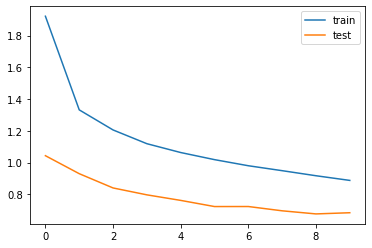

In [31]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# seq2seq + attention으로 요약 모델 테스트하기

In [32]:
src_index_to_word = src_tokenizer.index_word
tar_word_to_index = tar_tokenizer.word_index
tar_index_to_word = tar_tokenizer.index_word

In [33]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

In [34]:
# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

In [35]:
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [36]:
# 이전 시점의 상태들을 저장하는 텐서
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

In [37]:
# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

In [38]:
# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [39]:
def decode_sequence(input_seq):
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if(sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        e_h, e_c = h, c

    return decoded_sentence

# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [42]:
encoder_input_test = test["total"]
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_max_len, padding='post')

In [44]:
from tqdm import tqdm

summary = []
for i in tqdm(range(len(encoder_input_test))):
    summary.append(decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))

100%|██████████| 506/506 [07:27<00:00,  1.13it/s]


In [45]:
sample_submission["summary"] = summary

sample_submission.to_csv("base_submission.csv", index = False)

In [46]:
sample_submission.head()

,uid,summary
0,id_2000-AGENDA_1,음성군의회 음성군의회 임시회 제1차 본회의 개의 선포
1,id_2000-AGENDA_2,음성군의회 음성군의회 임시회 회기는 4월 25일부터 4월 30일까지 3일간으로 가결됨
2,id_2000-AGENDA_3,음성군의회 임시회 회의록 서명의원으로 반광홍 의원 정지태 의원이 선출됨
3,id_2000-AGENDA_4,음성군의회 임시회 회의록 서명의원으로 반광홍 의원 정지태 의원이 선출됨
4,id_2000-AGENDA_5,음성군의회 음성군의회 임시회 제1차 본회의 개의 선포
